In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import io
import requests
from bs4 import BeautifulSoup
import urllib.request
import re
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.19.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.70 MB/s
geopy-1.19.0-p 100% |################################| Time: 0:00:00  35.79 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  54.65 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  34.15 MB/s
vincent-0.4.4- 100% |###################

In [2]:
CLIENT_ID = 'IRL1XQA1FN233DQNZPQI0DU5JWF0WGCJYFSP1LIO3NM4UPSU' # your Foursquare ID
CLIENT_SECRET = 'MDLPPVB0ZTBZ1F0PX003VZXVY032X5JTZP2WKYXLTZOLV1OP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Create a dataframe containing district name, latitude and longtude of 23 districts in Tokyo Metropolitan Area.

In [22]:
tokyo = pd.DataFrame(np.array([['chiyoda', 35.69389, 139.75361], ['chuo', 35.67083, 139.77222], ['minato', 35.65806, 139.75167],['shinjuku', 35.69389, 139.70361],
                              ['bunkyo', 35.70806, 139.75222],['daito', 35.71278, 139.78],['sumida', 35.71056, 139.80167],['koto', 35.67306, 139.81722],
                              ['shinagawa', 35.60889, 139.73028],['meguro', 35.64139, 139.69833],['ota', 35.56139, 139.71611],['setagaya', 35.64611, 139.65306],
                              ['shibuya', 35.664145, 139.698504],['nakano', 35.7075, 139.66389],['suginami', 35.69944, 139.63639],['toyoshima', 35.72611, 139.71667],
                              ['kita', 35.75278, 139.73361],['arakawa', 35.73611, 139.78333],['itahashi', 35.75111, 139.70944],['nerima', 35.73556, 139.65222],
                               ['adachi', 35.775, 139.80472],['katsushika', 35.74333, 139.84722],['edokawa', 35.70667, 139.86833]])
                             , columns=['district', 'latitude', 'longitude'])
tokyo.shape

(23, 3)

### print the first 10 district data, set cordinates data type to float

In [23]:
tokyo.head(10)

,district,latitude,longitude
0,chiyoda,35.69389,139.75361
1,chuo,35.67083,139.77222
2,minato,35.65806,139.75167
3,shinjuku,35.69389,139.70361
4,bunkyo,35.70806,139.75222
5,daito,35.71278,139.78
6,sumida,35.71056,139.80167
7,koto,35.67306,139.81722
8,shinagawa,35.60889,139.73028
9,meguro,35.64139,139.69833


In [40]:
tokyo.latitude=tokyo.latitude.astype(float)
tokyo.longitude=tokyo.longitude.astype(float)
tokyo.dtypes

district      object
latitude     float64
longitude    float64
dtype: object

### Create a map of Tokyo Metropolitan Area with 23 districts marked on the map

In [41]:
address = 'tokyo'

geolocator = Nominatim(user_agent="tokyo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tokyo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tokyo are 35.6828387, 139.7594549.


In [42]:
map_tokyo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(tokyo['latitude'], tokyo['longitude'], tokyo['district']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
map_tokyo

### Explore top 100 popular venues in Minato District within a radius of 500 meters

In [47]:
minato_latitude = tokyo.loc[2, 'latitude'] # neighborhood latitude value
minato_longitude = tokyo.loc[2, 'longitude'] # neighborhood longitude value

minato_name = tokyo.loc[2, 'district'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(minato_name, 
                                                               minato_latitude, 
                                                               minato_longitude))

Latitude and longitude values of minato are 35.65806, 139.75167.


In [48]:
LIMIT = 100 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    minato_latitude, 
    minato_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=IRL1XQA1FN233DQNZPQI0DU5JWF0WGCJYFSP1LIO3NM4UPSU&client_secret=MDLPPVB0ZTBZ1F0PX003VZXVY032X5JTZP2WKYXLTZOLV1OP&v=20180605&ll=35.65806,139.75167&radius=500&limit=100'

In [49]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cc084209fb6b756b4484f80'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4d105d3ca3d9721e61a8d4fd-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'primary': True,
         'shortName': 'Bakery'}],
       'id': '4d105d3ca3d9721e61a8d4fd',
       'location': {'address': '芝公園3-3-1',
        'cc': 'JP',
        'city': '東京',
        'country': '日本',
        'crossStreet': '東京プリンスホテル',
        'distance': 146,
        'formattedAddress': ['芝公園3-3-1 (東京プリンスホテル)',
         '港区, 東京都',
         '105-8560',
         '日本'],
        'labeledLatLngs': [{'label': 'display',
          'lat':

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Le Pain Quotidien,Bakery,35.658251,139.750069
1,Mihousai (味芳斎 支店),Chinese Restaurant,35.659039,139.752649
2,泉州屋台,Thai Restaurant,35.656370,139.751330
3,Syoutaien (正泰苑),BBQ Joint,35.657981,139.753800
4,Zojoji Temple (増上寺),Buddhist Temple,35.657426,139.748301


In [52]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

86 venues were returned by Foursquare.


### Create a function to explore all the 23 districts in Tokyo

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['district', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
tokyo_venues = getNearbyVenues(names=tokyo['district'],
                                   latitudes=tokyo['latitude'],
                                   longitudes=tokyo['longitude']
                                  )

chiyoda
chuo
minato
shinjuku
bunkyo
daito
sumida
koto
shinagawa
meguro
ota
setagaya
shibuya
nakano
suginami
toyoshima
kita
arakawa
itahashi
nerima
adachi
katsushika
edokawa


In [56]:
print(tokyo_venues.shape)
tokyo_venues.head()

(1498, 7)


,district,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,chiyoda,35.69389,139.75361,Kanda Tendonya (神田天丼家),35.695765,139.754682,Tempura Restaurant
1,chiyoda,35.69389,139.75361,Jimbocho Kurosu (神保町 黒須),35.695539,139.754851,Ramen Restaurant
2,chiyoda,35.69389,139.75361,Shimizumon Gate (清水門),35.692685,139.752681,Historic Site
3,chiyoda,35.69389,139.75361,Nippon Budokan (日本武道館),35.693356,139.749865,Stadium
4,chiyoda,35.69389,139.75361,Kitanomaru Park (北の丸公園),35.691653,139.751201,Park


In [58]:
tokyo_venues.groupby('district').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
district,,,,,,
adachi,23,23,23,23,23,23
arakawa,14,14,14,14,14,14
bunkyo,100,100,100,100,100,100
chiyoda,95,95,95,95,95,95
chuo,100,100,100,100,100,100
daito,70,70,70,70,70,70
edokawa,24,24,24,24,24,24
itahashi,45,45,45,45,45,45
katsushika,28,28,28,28,28,28


In [59]:
print('There are {} uniques categories.'.format(len(tokyo_venues['Venue Category'].unique())))

There are 207 uniques categories.


### Analyze each District

In [60]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['district'] = tokyo_venues['district'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()

,district,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Fabric Shop,Fast Food Restaurant,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Kaiseki Restaurant,Karaoke Box,Korean Restaurant,Kushikatsu Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Men's Store,Mexican Restaurant,Mobile Phone Shop,Monjayaki Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nabe Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Sukiyaki Restaurant,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Tempura Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toll Booth,Tonkatsu Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [62]:
tokyo_onehot.shape

(1498, 208)

In [63]:
tokyo_grouped = tokyo_onehot.groupby('district').mean().reset_index()
tokyo_grouped

,district,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Fabric Shop,Fast Food Restaurant,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Kaiseki Restaurant,Karaoke Box,Korean Restaurant,Kushikatsu Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Men's Store,Mexican Restaurant,Mobile Phone Shop,Monjayaki Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nabe Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Sukiyaki Restaurant,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Tempura Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toll Booth,Tonkatsu Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,adachi,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,0.000000,0.00,0.000000,0.043478,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217391,0.00,0.000000,0.000000,0.00,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.043478,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.086957,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.086957,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.043478,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0

In [64]:
tokyo_grouped.shape

(23, 208)

In [65]:
num_top_venues = 5

for hood in tokyo_grouped['district']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['district'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----adachi----
               venue  freq
0  Convenience Store  0.22
1           Bus Stop  0.13
2      Grocery Store  0.09
3   Ramen Restaurant  0.09
4         Restaurant  0.09


----arakawa----
                   venue  freq
0      Convenience Store  0.21
1               Bus Stop  0.14
2                   Park  0.14
3  General Entertainment  0.07
4     Italian Restaurant  0.07


----bunkyo----
                 venue  freq
0    Convenience Store  0.08
1     Baseball Stadium  0.08
2     Ramen Restaurant  0.05
3          Coffee Shop  0.04
4  Japanese Restaurant  0.03


----chiyoda----
                venue  freq
0                Café  0.07
1   Convenience Store  0.07
2         Coffee Shop  0.06
3    Ramen Restaurant  0.06
4  Chinese Restaurant  0.04


----chuo----
                 venue  freq
0  Japanese Restaurant  0.09
1          Coffee Shop  0.06
2      Soba Restaurant  0.06
3     Ramen Restaurant  0.06
4     Sushi Restaurant  0.05


----daito----
               venue  freq
0  Conveni

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Show the top 10 most popular venue types in all the 23 districts

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['district'] = tokyo_grouped['district']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,adachi,Convenience Store,Bus Stop,Grocery Store,Intersection,Restaurant,Ramen Restaurant,Donburi Restaurant,BBQ Joint,Furniture / Home Store,Music Venue
1,arakawa,Convenience Store,Park,Bus Stop,Tram Station,General Entertainment,Café,Indian Restaurant,Intersection,Italian Restaurant,Chinese Restaurant
2,bunkyo,Baseball Stadium,Convenience Store,Ramen Restaurant,Coffee Shop,Café,Concert Hall,Italian Restaurant,Japanese Restaurant,BBQ Joint,Korean Restaurant
3,chiyoda,Convenience Store,Café,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Historic Site,Japanese Curry Restaurant,Japanese Restaurant,Sake Bar,Dumpling Restaurant
4,chuo,Japanese Restaurant,Coffee Shop,Ramen Restaurant,Soba Restaurant,Sushi Restaurant,Italian Restaurant,Convenience Store,Hotel,Wine Bar,Kaiseki Restaurant


### Cluster the districts

In [69]:
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('district', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 0, 0, 0, 2, 1, 2, 4, 3], dtype=int32)

In [70]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = tokyo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('district'), on='district')

tokyo_merged.head() # check the last columns!

,district,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,chiyoda,35.69389,139.75361,0,Convenience Store,Café,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Historic Site,Japanese Curry Restaurant,Japanese Restaurant,Sake Bar,Dumpling Restaurant
1,chuo,35.67083,139.77222,0,Japanese Restaurant,Coffee Shop,Ramen Restaurant,Soba Restaurant,Sushi Restaurant,Italian Restaurant,Convenience Store,Hotel,Wine Bar,Kaiseki Restaurant
2,minato,35.65806,139.75167,0,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Convenience Store,Yoshoku Restaurant,Ramen Restaurant,Park,Coffee Shop,Tonkatsu Restaurant,Steakhouse
3,shinjuku,35.69389,139.70361,0,Bar,Sake Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Yakitori Restaurant,Soba Restaurant,Chinese Restaurant,Shabu-Shabu Restaurant,Rock Club
4,bunkyo,35.70806,139.75222,0,Baseball Stadium,Convenience Store,Ramen Restaurant,Coffee Shop,Café,Concert Hall,Italian Restaurant,Japanese Restaurant,BBQ Joint,Korean Restaurant


### Create the clustered districts on map

In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['latitude'], tokyo_merged['longitude'], tokyo_merged['district'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each cluster

In [74]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[0] + list(range(3, tokyo_merged.shape[1]))]]

,district,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,chiyoda,0,Convenience Store,Café,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Historic Site,Japanese Curry Restaurant,Japanese Restaurant,Sake Bar,Dumpling Restaurant
1,chuo,0,Japanese Restaurant,Coffee Shop,Ramen Restaurant,Soba Restaurant,Sushi Restaurant,Italian Restaurant,Convenience Store,Hotel,Wine Bar,Kaiseki Restaurant
2,minato,0,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Convenience Store,Yoshoku Restaurant,Ramen Restaurant,Park,Coffee Shop,Tonkatsu Restaurant,Steakhouse
3,shinjuku,0,Bar,Sake Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Yakitori Restaurant,Soba Restaurant,Chinese Restaurant,Shabu-Shabu Restaurant,Rock Club
4,bunkyo,0,Baseball Stadium,Convenience Store,Ramen Restaurant,Coffee Shop,Café,Concert Hall,Italian Restaurant,Japanese Restaurant,BBQ Joint,Korean Restaurant
9,meguro,0,Japanese Restaurant,Café,BBQ Joint,Italian Restaurant,Ramen Restaurant,Coffee Shop,French Restaurant,Yakitori Restaurant,Thai Restaurant,Bakery
10,ota,0,Ramen Restaurant,Sake Bar,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,Tonkatsu Restaurant,Italian Restaurant,Sushi Restaurant,Steakhouse,Noodle House
12,shibuya,0,Café,Record Shop,Ramen Restaurant,Rock Club,Nightclub,Clothing Store,Japanese Restaurant,Furniture / Home Store,Chinese Restaurant,BBQ Joint
13,nakano,0,Ramen Restaurant,Sake Bar,Japanese Restaurant,Bar,Café,Italian Restaurant,Japanese Curry Restaurant,Theater,BBQ Joint,Convenience Store
14,suginami,0,Coffee Shop,Shopping Mall,Ramen Restaurant,Café,Italian Restaurant,Chinese Restaurant,Grocery Store,Sushi Restaurant,Shabu-Shabu Restaurant,BBQ Joint


In [75]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[0] + list(range(3, tokyo_merged.shape[1]))]]

,district,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,adachi,1,Convenience Store,Bus Stop,Grocery Store,Intersection,Restaurant,Ramen Restaurant,Donburi Restaurant,BBQ Joint,Furniture / Home Store,Music Venue
22,edokawa,1,Convenience Store,Grocery Store,Unagi Restaurant,Restaurant,Electronics Store,Concert Hall,Clothing Store,Furniture / Home Store,Bus Stop,Park


In [76]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 2, tokyo_merged.columns[[0] + list(range(3, tokyo_merged.shape[1]))]]

,district,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,daito,2,Convenience Store,Sake Bar,Ramen Restaurant,Hotel,Art Museum,Bookstore,Bath House,Café,Soba Restaurant,Cocktail Bar
6,sumida,2,Convenience Store,Japanese Restaurant,Unagi Restaurant,Soba Restaurant,Sake Bar,Café,Coffee Shop,Ramen Restaurant,Wagashi Place,Park
7,koto,2,Convenience Store,Coffee Shop,Ramen Restaurant,Sake Bar,Japanese Restaurant,Donburi Restaurant,Chinese Restaurant,Supermarket,Park,Japanese Curry Restaurant
8,shinagawa,2,Convenience Store,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant,Italian Restaurant,Coffee Shop,Japanese Restaurant,Sake Bar,Diner,Theater
11,setagaya,2,Convenience Store,Café,Ramen Restaurant,Sake Bar,Tram Station,Park,Bakery,Bath House,Shanghai Restaurant,Beer Bar
18,itahashi,2,Convenience Store,Ramen Restaurant,Japanese Restaurant,Shopping Mall,Noodle House,Grocery Store,Indian Restaurant,Dessert Shop,Drugstore,Sake Bar
19,nerima,2,Ramen Restaurant,Convenience Store,Grocery Store,Café,Sake Bar,Italian Restaurant,Coffee Shop,BBQ Joint,Chinese Restaurant,Boutique


In [77]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 3, tokyo_merged.columns[[0] + list(range(3, tokyo_merged.shape[1]))]]

,district,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,kita,3,Convenience Store,Ramen Restaurant,Intersection,Park,Theater,Japanese Restaurant,Coffee Shop,Soba Restaurant,Bed & Breakfast,Bath House
17,arakawa,3,Convenience Store,Park,Bus Stop,Tram Station,General Entertainment,Café,Indian Restaurant,Intersection,Italian Restaurant,Chinese Restaurant


In [78]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 4, tokyo_merged.columns[[0] + list(range(3, tokyo_merged.shape[1]))]]

,district,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,katsushika,4,Supermarket,Intersection,Convenience Store,Bus Stop,Discount Store,Sushi Restaurant,Office,Motorcycle Shop,Clothing Store,Grocery Store


### Last present number of residents by district

In [105]:
Population = pd.DataFrame(np.array([['chiyoda', 63635], ['chuo', 162502], ['minato', 257426],['shinjuku', 346162],
                              ['bunkyo', 221489],['daito', 199292],['sumida', 271859],['koto', 518479],
                              ['shinagawa', 394700],['meguro', 279342],['ota', 729534],['setagaya', 908907],
                              ['shibuya', 226594],['nakano', 331658],['suginami', 569132],['toyoshima', 289508],
                              ['kita', 351976],['arakawa', 215966],['itahashi', 566890],['nerima', 732433],
                               ['adachi', 688512],['katsushika', 462591],['edokawa', 698031]])
                             , columns=['district', 'population'])
Population.shape

(23, 2)

In [106]:
Population.dtypes

district      object
population    object
dtype: object

In [107]:
Population.head()

,district,population
0,chiyoda,63635
1,chuo,162502
2,minato,257426
3,shinjuku,346162
4,bunkyo,221489


In [108]:
Population.population = Population.population.astype(int)
Population.district = Population.district.astype(str)
Population.dtypes

district      object
population     int64
dtype: object

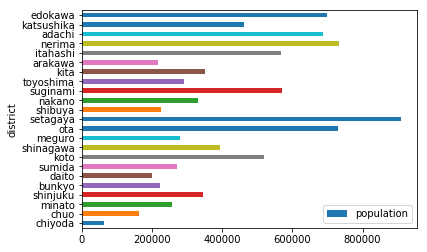

In [112]:
import matplotlib.pyplot as plt
ax = Population.plot.barh(x='district', y='population')